In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from wordcloud import WordCloud
from collections import Counter

from constants import *

# Исправление ссылок в первом файле

In [2]:
df = pd.read_csv('data/base/publications_page_1.csv')
df.head(5)

,Название,Ссылка на статью,Авторы,Цитирования
0,ENERGY VALUE CHAIN AND ECONOMIC IMPACT: ASSESS...,https://elibrary.ru/item.asp?id=80386839,"Zhou J., Abbas A., Vasbieva D.G.",0
1,NaN,https://elibrary.rujavascript:url_article(7960...,"Mikeš J., Stepanov S.E., Tsyganok I.I.",0
2,NaN,https://elibrary.rujavascript:url_article(7993...,"Krechko O., Mikhaylov A.",2
3,NaN,https://elibrary.rujavascript:url_article(8168...,"Mikhaylov A., Yousif N.B.A., Dincer H., Yüksel...",1
4,NaN,https://elibrary.rujavascript:url_article(8272...,"Mikheev P.V., Lebedev A.K., Borisova L.R.",0


In [ ]:
def fix_func(x):
    start_index = x.find('(')
    if start_index != -1:
        return 'https://elibrary.ru/item.asp?id=' + x[start_index + 1: start_index + 9]
    return x

df['Ссылка на статью'] = df['Ссылка на статью'].apply(fix_func)
df.to_csv('data/publications_page_1.csv', index=False)

# Обработка данных

### Формирования общего датасета

In [2]:
# функция для получения eLIBRARY ID из ссылки на статью
def ela_id(link):
    start_index = link.find('=')
    if start_index !=1:
        return int(link[start_index + 1: start_index + 9])
    
# функция для объединения датафреймов из нескольких csv файлов
def df_concat(path, start_n, end_n):
    df = pd.read_csv(f'{path}{start_n}.csv')
    for i in range(start_n + 1, end_n):
        df2 = pd.read_csv(f'{path}{i}.csv')
        df = pd.concat([df, df2], ignore_index=True)
    return df

In [3]:
start_n = 1
end_n = 20

# собираем в один df csv первичной информации
path_base = 'data/base/publications_page_'
df_base = df_concat(path_base, start_n, end_n)

# создаем столбец eLIBRARY ID, удаляем дубли
df_base['eLIBRARY ID'] = df_base['Ссылка на статью'].apply(ela_id)
duplicates = df_base["eLIBRARY ID"].duplicated(keep=False)
print("Число дубликатов в df_base:", duplicates.sum())
df_base = df_base.drop_duplicates(subset=['eLIBRARY ID'])

# собираем в один df csv по журналам
path_juornals = 'data/journals/journals_page_'
df_journals = df_concat(path_juornals, start_n, end_n)

# собираем в один df csv по статьям
path_articles = 'data/articles/articles_page_'
df_articles = df_concat(path_articles, start_n, end_n)

# для журналов объединяем файлы, добавляем столбец eLIBRARY ID, переименовываем столбец "Название", удаляем столбец DOI и Ссылка на статью
df_journals['eLIBRARY ID'] = df_journals['Ссылка на статью'].apply(ela_id)
df_journals.rename(columns={'Название': 'Название журнала'}, inplace=True)
df_journals.drop(columns=['DOI', 'Ссылка на статью'], inplace=True)

# соединяем, удаляем дубли 
df_articles = df_articles.merge(df_journals, on=["eLIBRARY ID"])
duplicates = df_articles["eLIBRARY ID"].duplicated(keep=False)
print("Число дубликатов в df_articles:", duplicates.sum())
df_articles = df_articles.drop_duplicates(subset=['eLIBRARY ID'])

# добавляем цитирования
df_articles = df_articles.merge(df_base[['eLIBRARY ID', 'Цитирования']], on=["eLIBRARY ID"], how='left')
df_articles.to_csv(f'data/articles_full_{start_n}_{end_n - 1}.csv', index=False)


Число дубликатов в df_base: 26
Число дубликатов в df_articles: 52


In [4]:
# заполняем пропущенные значения year
data = pd.read_csv(f'data/articles_1_43.csv')
data = data[['eLIBRARY ID', 'year']]

df = pd.read_csv(f'data/articles_full_{start_n}_{end_n - 1}.csv')
df = df.merge(data[['eLIBRARY ID', 'year']], on='eLIBRARY ID', how='left', suffixes=('', '_new'))

df['year'] = df['year'].fillna(df['year_new'])
df.drop(columns=['year_new'], inplace=True)
df.loc[df['year'].isna(), 'year'] = 2025

df.drop_duplicates(subset= ['eLIBRARY ID'], inplace=True)
df.to_csv(f'data/articles_full_{start_n}_{end_n - 1}.csv', index=False)

In [5]:
# объединяем датасеты, заполняем рубрику OECD - 'нет' 
df1 = pd.read_csv('data/articles_full_1_19.csv')
df2 = pd.read_csv('data/articles_1_43.csv')

df2['OECD'] = 'нет'
df_merged = pd.concat([df1, df2], ignore_index=True)
print(df_merged['eLIBRARY ID'].duplicated(keep=False).sum())
df_merged.drop_duplicates(subset=['eLIBRARY ID'], inplace=True)
df_merged.info()
df_merged.to_csv('data/articles_full_1_43.csv', index=False)

2624
<class 'pandas.core.frame.DataFrame'>
Index: 4493 entries, 0 to 5804
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Ссылка на статью     4493 non-null   object 
 1   DOI                  4076 non-null   object 
 2   eLIBRARY ID          4493 non-null   float64
 3   article_type         4493 non-null   object 
 4   year                 4493 non-null   float64
 5   language             4493 non-null   object 
 6   title_en             4274 non-null   object 
 7   key_words_en         4232 non-null   object 
 8   abstract_en          4172 non-null   object 
 9   authors_metadata_en  4485 non-null   object 
 10  title_ru             1757 non-null   object 
 11  key_words_ru         1757 non-null   object 
 12  abstract_ru          1717 non-null   object 
 13  authors_metadata_ru  1757 non-null   object 
 14  OECD                 4493 non-null   object 
 15  Название журнала     3632 non-null   o

#### Язык

In [6]:
df = pd.read_csv(f'data/articles_full_1_43.csv')


# вручную исправляем языки для некоторых статей
# df[df['language'] == 'не определен']
spain_ids = [81516488, 68080647, 68080963, 62384591, 62242494]
df.loc[df['eLIBRARY ID'].isin(spain_ids), 'language'] = 'испанский'
df.loc[df['language'] == 'не определен', 'language'] = 'английский'
df.loc[df['language'] == 'английский, русский', 'language'] = 'русский, английский'

df.language.value_counts()

language
английский             2731
русский                1702
русский, английский      37
испанский                18
французский               3
португальский             1
итальянский               1
Name: count, dtype: int64

#### Рубрики

In [7]:
from constants import * #словари для рубрик, написанные в ручную

# создаем обратный словарь {subcategory: category}
subcat_to_cat = {}
for category, subcategories in FIRST_LEVEL.items():
    for sub in subcategories:
        subcat_to_cat[sub.lower()] = category

# заполняем столбец first_OECD - рубрика первичного уровня
df['first_OECD'] = (df['OECD'].fillna('нет').str.lower().map(subcat_to_cat).fillna('нет'))
df['first_OECD'].value_counts()    

first_OECD
нет                            3094
Social Sciences                 878
Natural Sciences                248
Humanities                      111
Engineering and Technology       88
Medical and Health Sciences      65
Agricultural Sciences             9
Name: count, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4493 entries, 0 to 4492
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Ссылка на статью     4493 non-null   object 
 1   DOI                  4076 non-null   object 
 2   eLIBRARY ID          4493 non-null   float64
 3   article_type         4493 non-null   object 
 4   year                 4493 non-null   float64
 5   language             4493 non-null   object 
 6   title_en             4274 non-null   object 
 7   key_words_en         4232 non-null   object 
 8   abstract_en          4172 non-null   object 
 9   authors_metadata_en  4485 non-null   object 
 10  title_ru             1757 non-null   object 
 11  key_words_ru         1757 non-null   object 
 12  abstract_ru          1717 non-null   object 
 13  authors_metadata_ru  1757 non-null   object 
 14  OECD                 4493 non-null   object 
 15  Название журнала     3632 non-null   o

#### Численные столбцы

In [11]:
for column in NUMERIC_COLUMNS:
    df[column] = df[column].astype("Int64")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4493 entries, 0 to 4492
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Ссылка на статью     4493 non-null   object
 1   DOI                  4076 non-null   object
 2   eLIBRARY ID          4493 non-null   Int64 
 3   article_type         4493 non-null   object
 4   year                 4493 non-null   Int64 
 5   language             4493 non-null   object
 6   title_en             4274 non-null   object
 7   key_words_en         4232 non-null   object
 8   abstract_en          4172 non-null   object
 9   authors_metadata_en  4485 non-null   object
 10  title_ru             1757 non-null   object
 11  key_words_ru         1757 non-null   object
 12  abstract_ru          1717 non-null   object
 13  authors_metadata_ru  1757 non-null   object
 14  OECD                 4493 non-null   object
 15  Название журнала     3632 non-null   object
 16  Издате

In [12]:
# coхраняем итоговый датасет
df.to_csv('data/final.csv', index=False)

# EDA

In [3]:
df = pd.read_csv('data/final.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4493 entries, 0 to 4492
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Ссылка на статью     4493 non-null   object 
 1   DOI                  4076 non-null   object 
 2   eLIBRARY ID          4493 non-null   int64  
 3   article_type         4493 non-null   object 
 4   year                 4493 non-null   int64  
 5   language             4493 non-null   object 
 6   title_en             4274 non-null   object 
 7   key_words_en         4232 non-null   object 
 8   abstract_en          4172 non-null   object 
 9   authors_metadata_en  4485 non-null   object 
 10  title_ru             1757 non-null   object 
 11  key_words_ru         1757 non-null   object 
 12  abstract_ru          1717 non-null   object 
 13  authors_metadata_ru  1757 non-null   object 
 14  OECD                 4493 non-null   object 
 15  Название журнала     3632 non-null   o

In [17]:
print(df.columns)


Index(['Ссылка на статью', 'DOI', 'eLIBRARY ID', 'article_type', 'year',
       'language', 'title_en', 'key_words_en', 'abstract_en',
       'authors_metadata_en', 'title_ru', 'key_words_ru', 'abstract_ru',
       'authors_metadata_ru', 'OECD', 'Название журнала', 'Издательство',
       'ISSN', 'eISSN', 'Цитирования', 'first_OECD'],
      dtype='object')


In [16]:
for column in CAT_COLUMNS:
    print(df[column].value_counts())

article_type
статья в журнале - научная статья           3398
статья в сборнике трудов конференции         656
статья в сборнике статей                     196
статья в журнале - материалы конференции      95
статья в журнале - глава в книге              42
статья в журнале - обзорная статья            36
статья в журнале - рецензия                   31
статья в журнале - краткое сообщение          16
глава в книге                                  8
статья в журнале - редакторская заметка        5
статья в журнале - персоналия                  5
статья в журнале - разное                      4
редакторская заметка                           1
Name: count, dtype: int64
year
2022    759
2023    709
2021    659
2024    631
2020    603
2019    455
2025    401
2018    182
2017     94
Name: count, dtype: int64
language
английский             2731
русский                1702
русский, английский      37
испанский                18
французский               3
португальский             1
итальянс

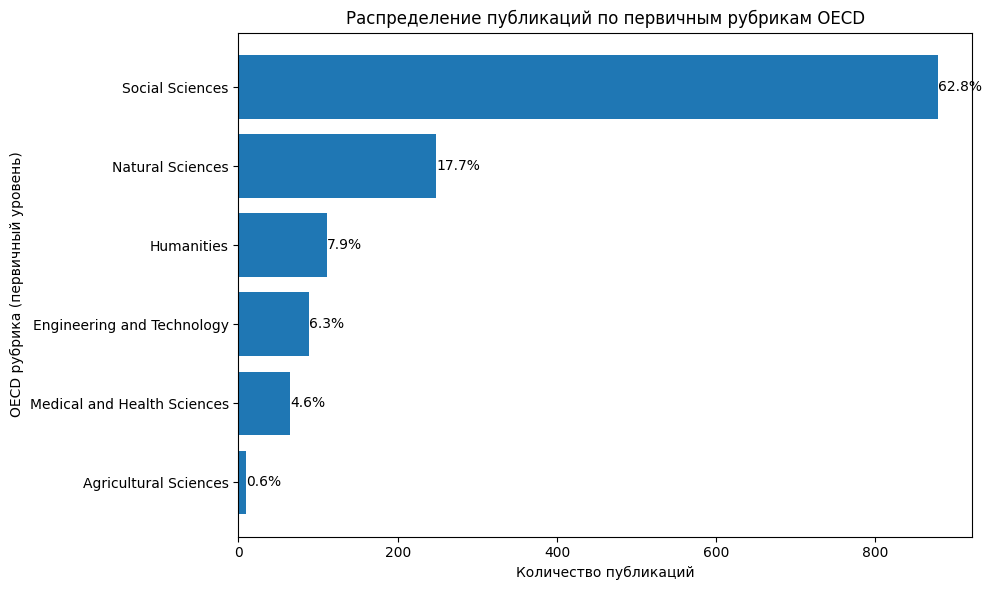

In [ ]:
# считаем категории, исключая "нет"
counts = (
    df['first_OECD']
    .value_counts()
    .loc[lambda s: s.index != 'нет']
    .sort_values(ascending=True)
)

total = counts.sum()  # общее количество для процентов

plt.figure(figsize=(10, 6))
bars = plt.barh(counts.index, counts.values)

# добавление процентов
for bar, value in zip(bars, counts.values):
    percent = value / total * 100
    plt.text(
        bar.get_width() + 0.5,   # чуть правее бара
        bar.get_y() + bar.get_height() / 2,
        f"{percent:.1f}%",       # формат: одна цифра после запятой
        va='center'
    )

plt.xlabel("Количество публикаций")
plt.ylabel("OECD рубрика (первичный уровень)")
plt.title("Распределение публикаций по первичным рубрикам OECD")

plt.tight_layout()
plt.show()


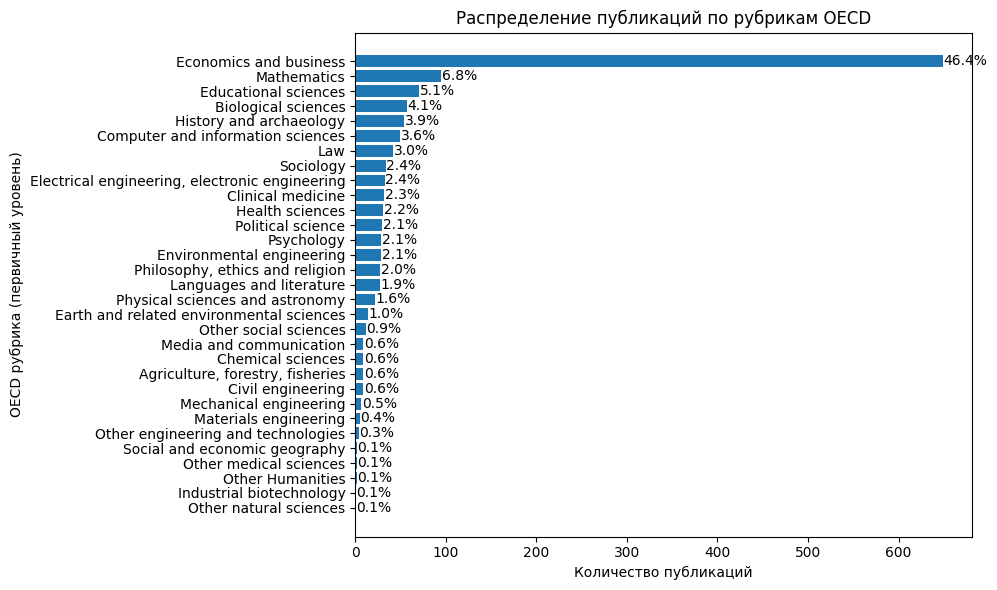

In [24]:
# считаем категории, исключая "нет"
counts = (
    df['OECD']
    .value_counts()
    .loc[lambda s: s.index != 'нет']
    .sort_values(ascending=True)
)

total = counts.sum()  # общее количество для процентов

plt.figure(figsize=(10, 6))
bars = plt.barh(counts.index, counts.values)

# добавление процентов
for bar, value in zip(bars, counts.values):
    percent = value / total * 100
    plt.text(
        bar.get_width() + 0.5,   # чуть правее бара
        bar.get_y() + bar.get_height() / 2,
        f"{percent:.1f}%",       # формат: одна цифра после запятой
        va='center'
    )

plt.xlabel("Количество публикаций")
plt.ylabel("OECD рубрика (первичный уровень)")
plt.title("Распределение публикаций по рубрикам OECD")

plt.tight_layout()
plt.show()


#### Журналы

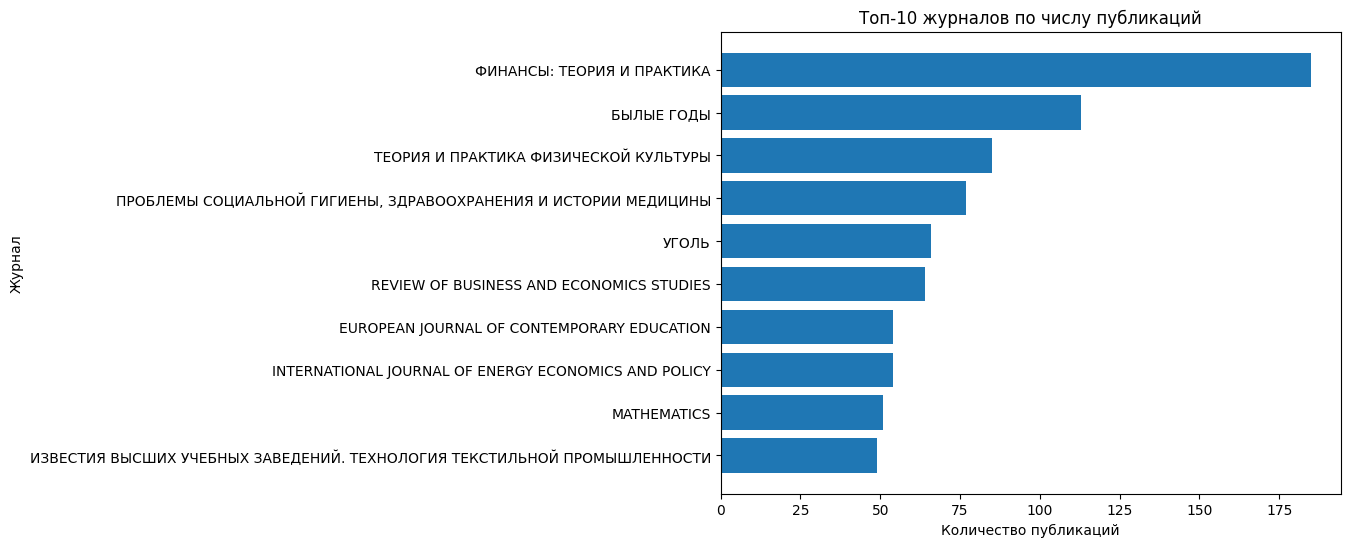

In [23]:
df_journals = df.dropna(subset=['Название журнала'])

top_journals_count = df_journals['Название журнала'].value_counts().head(10)
    
counts = top_journals_count.sort_values(ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(counts.index, counts.values)
plt.xlabel('Количество публикаций')
plt.ylabel('Журнал')
plt.title('Топ-10 журналов по числу публикаций')
plt.show()



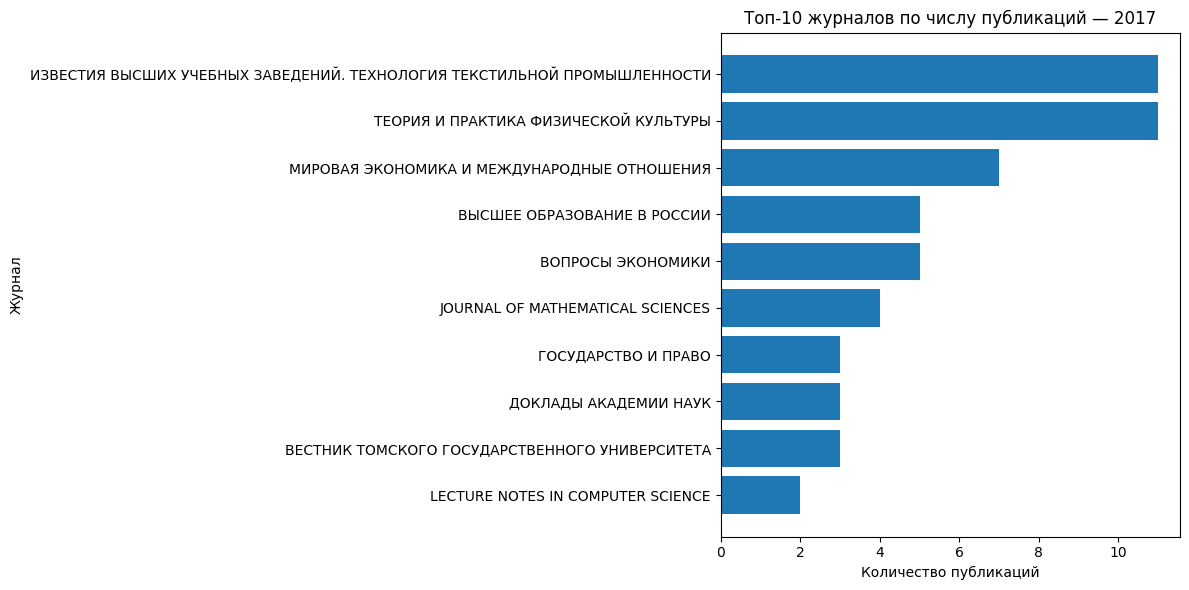

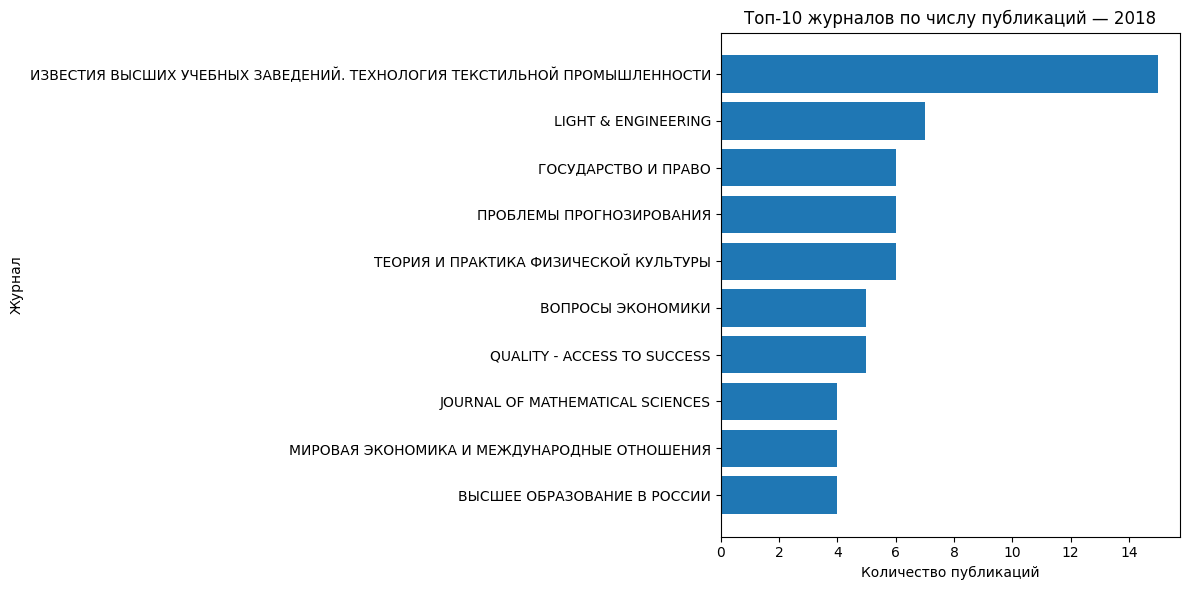

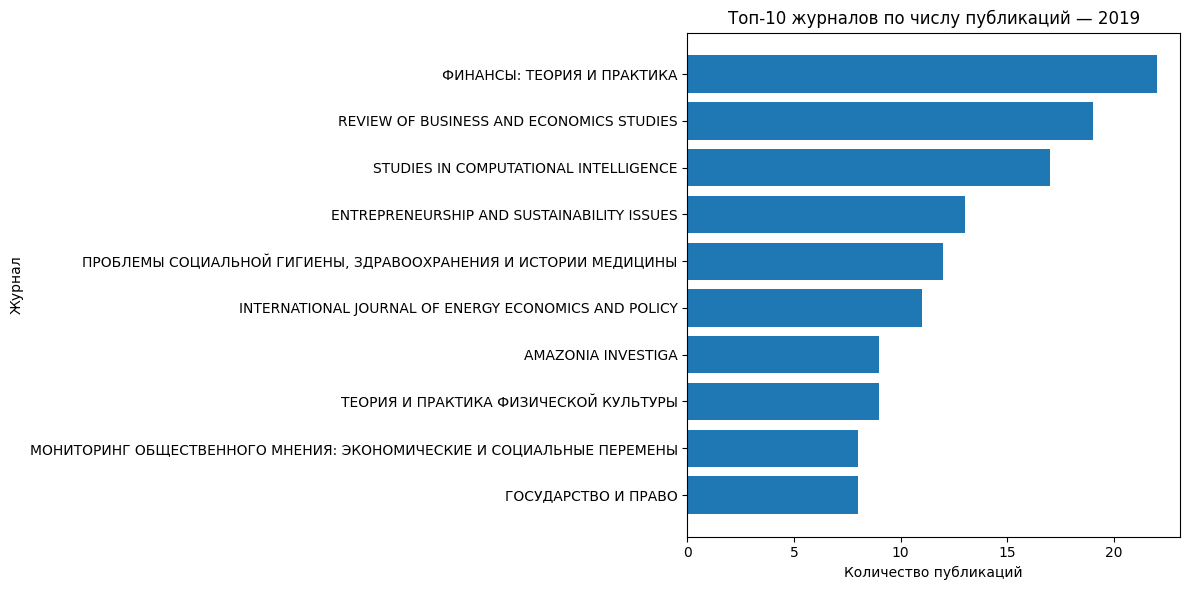

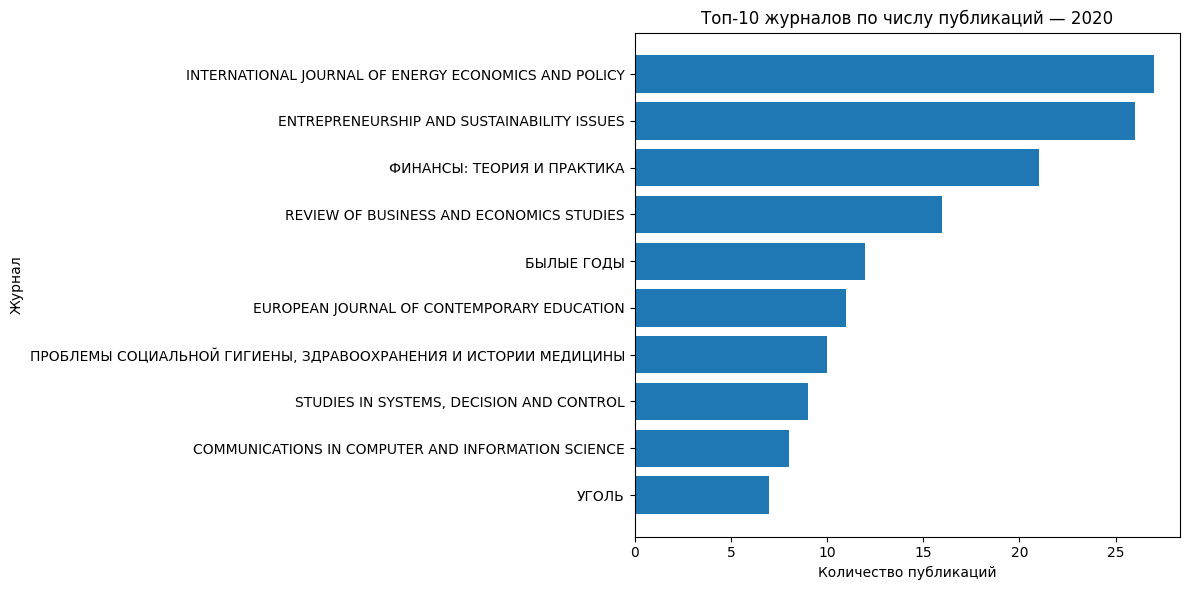

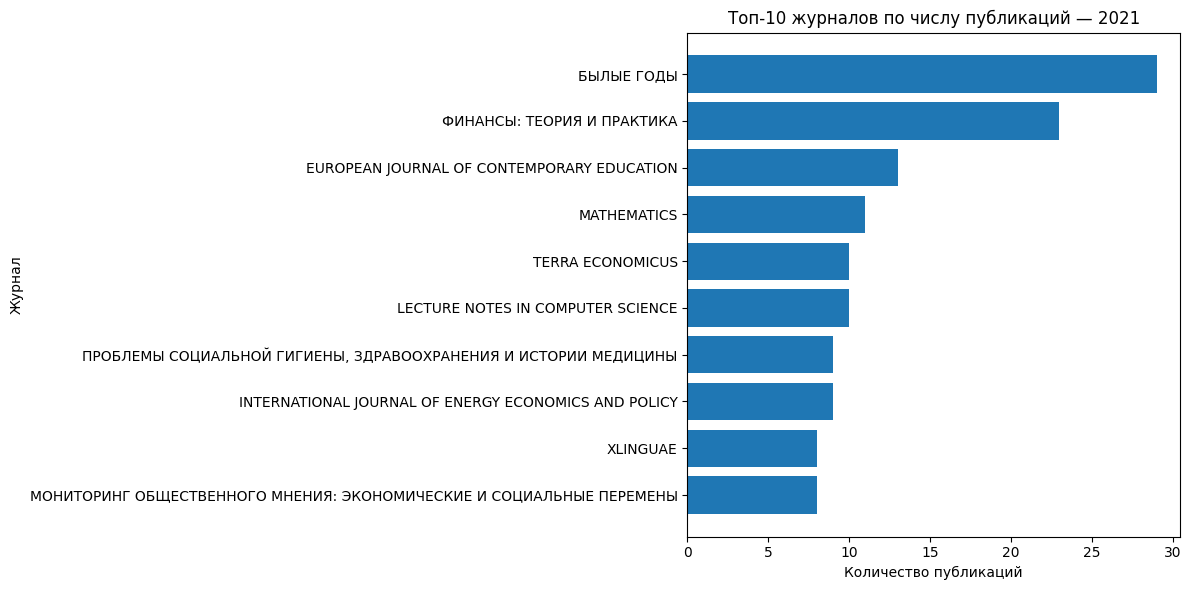

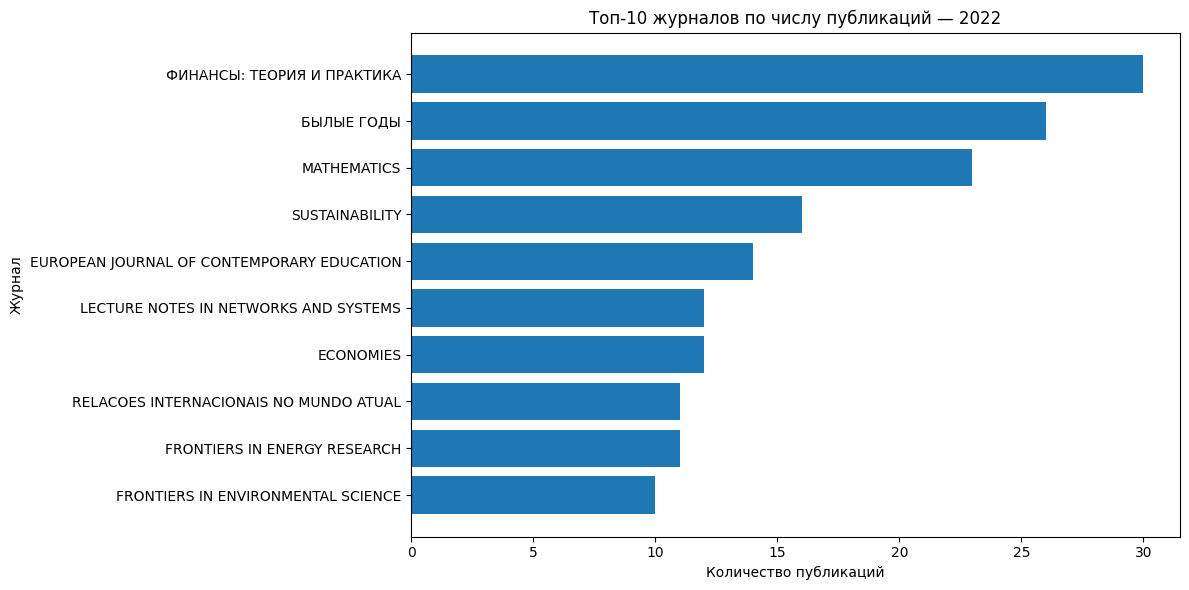

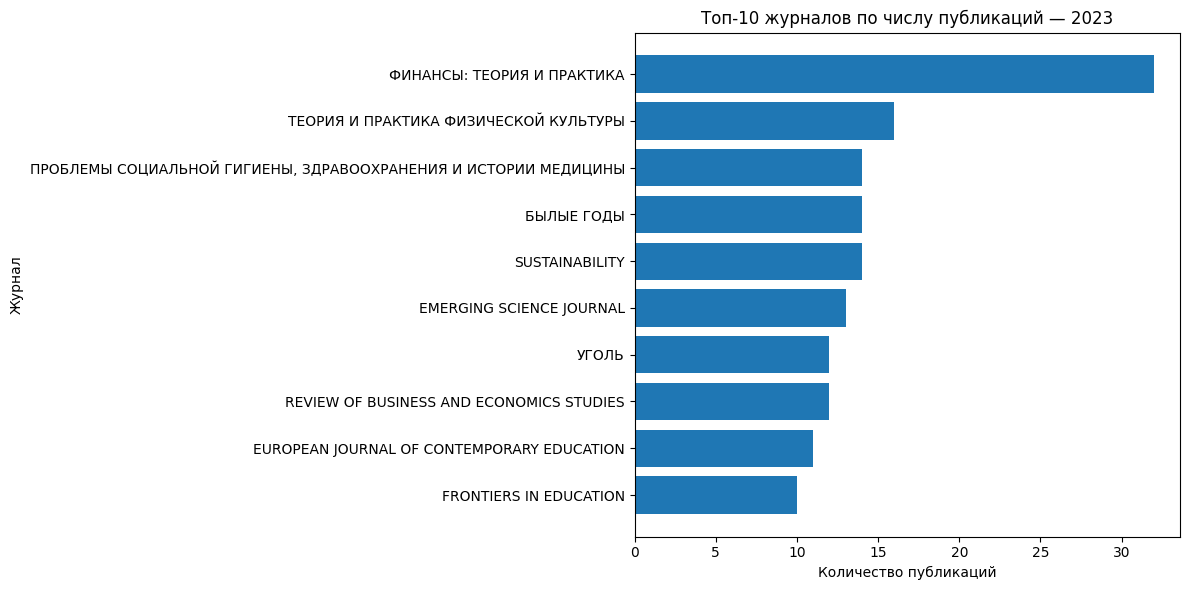

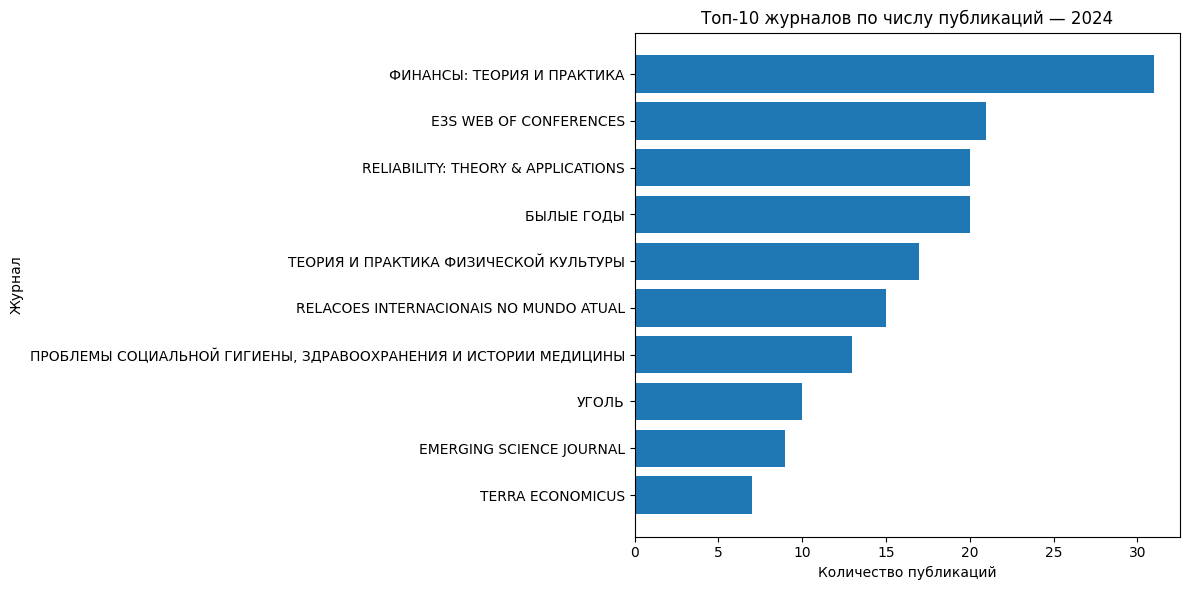

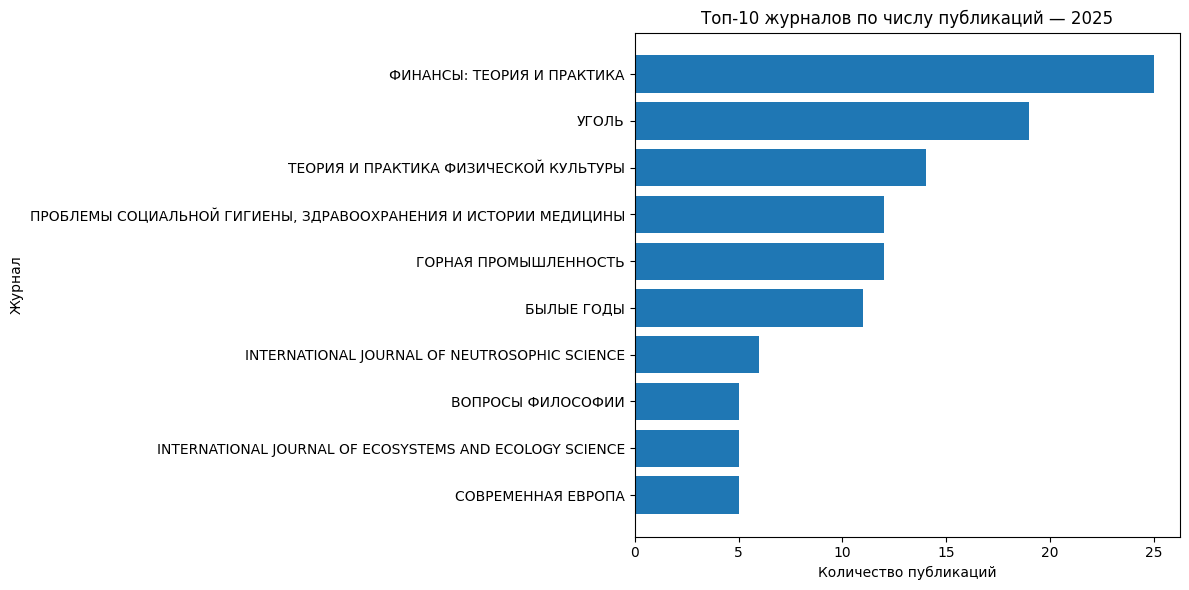

In [27]:
# убираем строки без названия журнала
df_journals = df.dropna(subset=['Название журнала'])

# список всех лет в данных
years = sorted(df_journals['year'].dropna().unique())

for year in years:
    df_year = df_journals[df_journals['year'] == year]

    # считаем топ-10 журналов
    top_journals = df_year['Название журнала'].value_counts().head(10)
    counts = top_journals.sort_values(ascending=True)

    # строим график
    plt.figure(figsize=(12, 6))
    plt.barh(counts.index, counts.values)
    plt.xlabel('Количество публикаций')
    plt.ylabel('Журнал')
    plt.title(f'Топ-10 журналов по числу публикаций — {year}')
    plt.tight_layout()
    plt.show()


In [42]:
df.to_csv(f'data/articles_full_{start_n}_{end_n - 1}.csv', index=False)

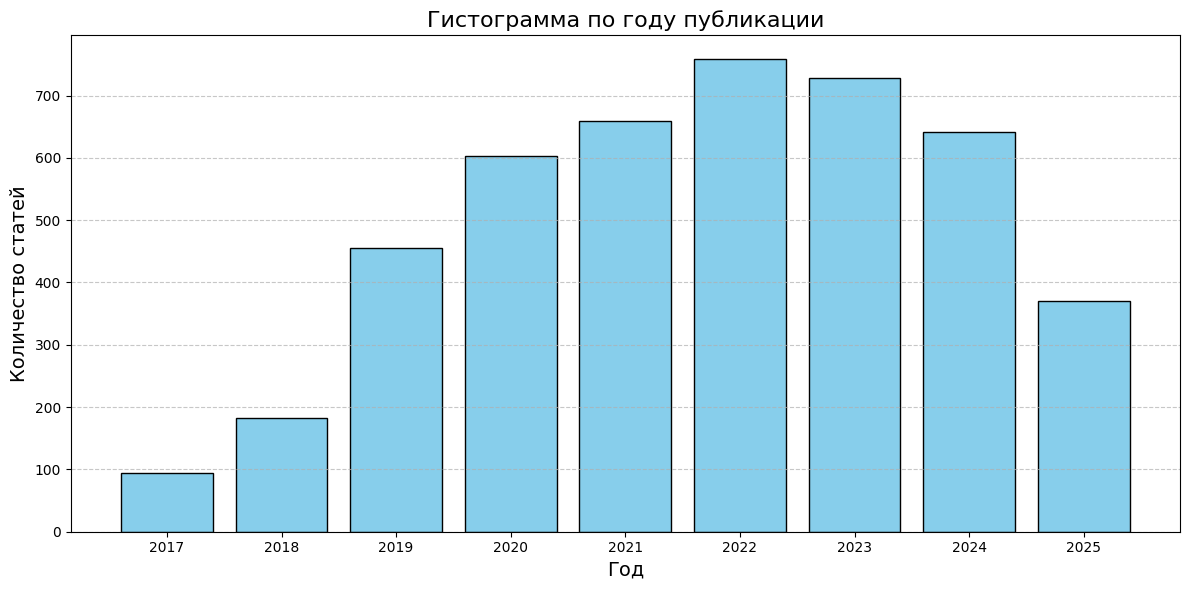

In [44]:
df = pd.read_csv('data/final.csv')

df_years = df.dropna(subset=['year']).copy()
df_years['year'] = df_years['year'].astype(int)

year_counts = df_years['year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(year_counts.index, year_counts.values, color='skyblue', edgecolor='black')
plt.title('Гистограмма по году публикации', fontsize=16)
plt.xlabel('Год', fontsize=14)
plt.ylabel('Количество статей', fontsize=14)
plt.xticks(year_counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

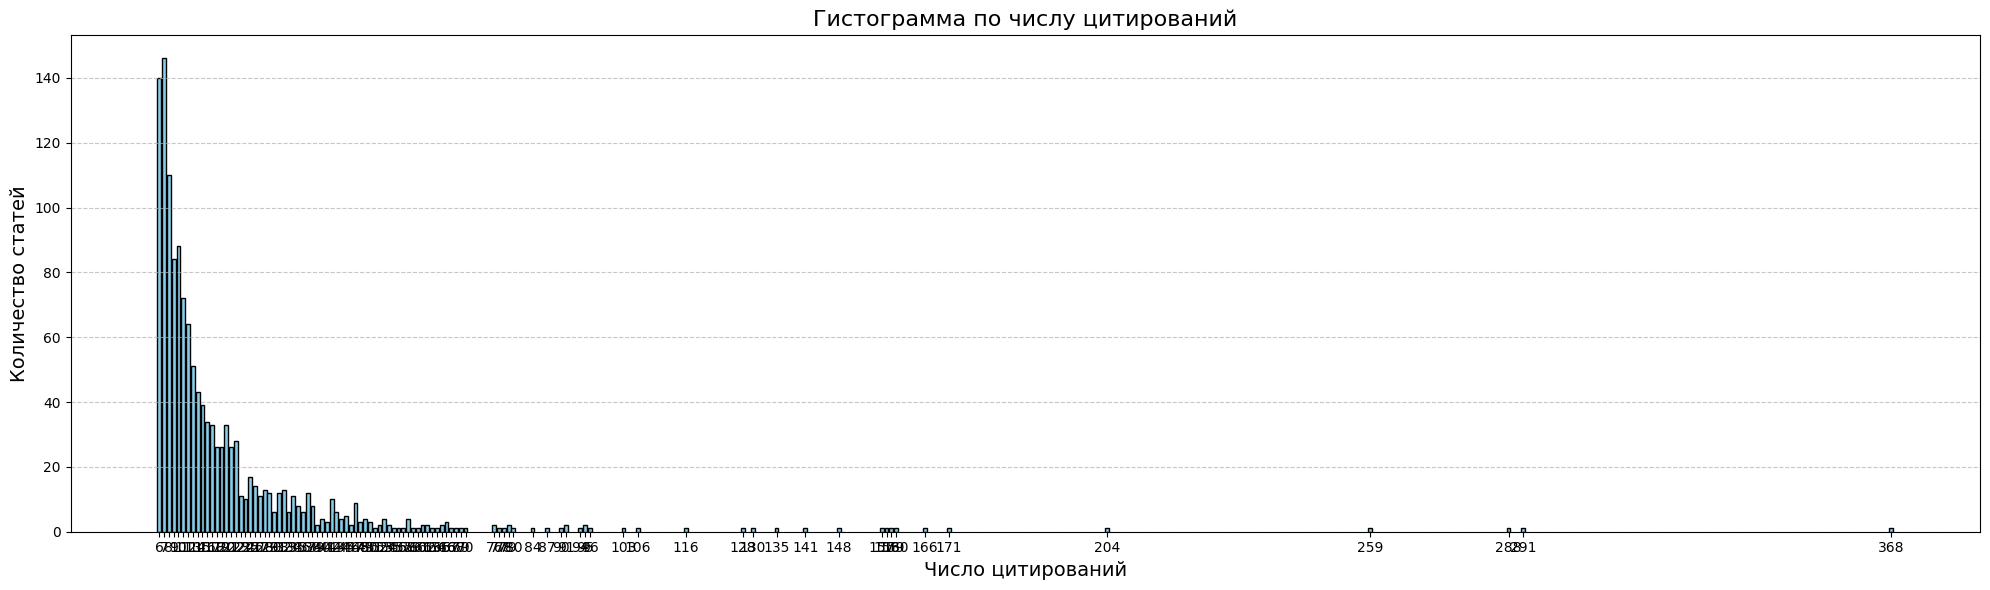

In [45]:
df_c = df.dropna(subset=['Цитирования']).copy()
df_c['Цитирования'] = df_c['Цитирования'].astype(int)
df_c = df_c[df_c['Цитирования'] > 5]  
#df_c = df_c[df_c['Цитирования'] < 100]

citation_counts = df_c['Цитирования'].value_counts().sort_index()


plt.figure(figsize=(20, 6))
plt.bar(citation_counts.index, citation_counts.values, color='skyblue', edgecolor='black')
plt.title('Гистограмма по числу цитирований', fontsize=16)
plt.xlabel('Число цитирований', fontsize=14)
plt.ylabel('Количество статей', fontsize=14)
plt.xticks(citation_counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [47]:
df['language'].dropna().value_counts()

language
английский             2731
русский                1702
русский, английский      36
испанский                18
французский               3
португальский             1
английский, русский       1
итальянский               1
Name: count, dtype: int64

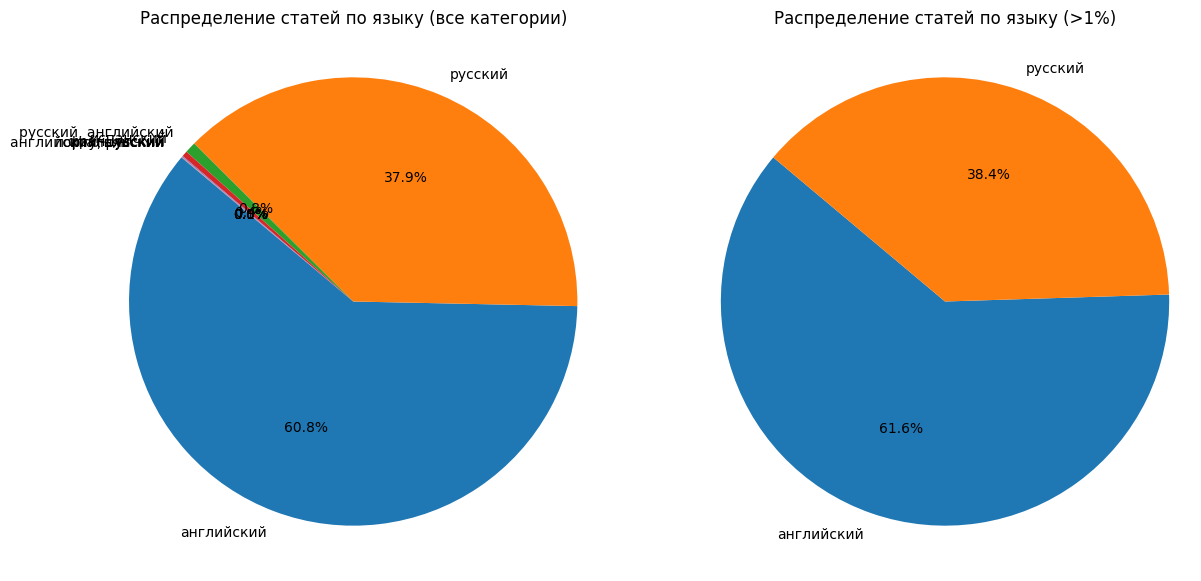

In [46]:
lang_counts = df['language'].dropna().value_counts()

total = lang_counts.sum()
filtered_counts = lang_counts[lang_counts / total >= 0.01]

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].pie(lang_counts, labels=lang_counts.index, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Распределение статей по языку (все категории)')
axes[0].axis('equal')

axes[1].pie(filtered_counts, labels=filtered_counts.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Распределение статей по языку (>1%)')
axes[1].axis('equal')

plt.show()

In [48]:
df['article_type'].value_counts()

article_type
статья в журнале - научная статья           3398
статья в сборнике трудов конференции         656
статья в сборнике статей                     196
статья в журнале - материалы конференции      95
статья в журнале - глава в книге              42
статья в журнале - обзорная статья            36
статья в журнале - рецензия                   31
статья в журнале - краткое сообщение          16
глава в книге                                  8
статья в журнале - редакторская заметка        5
статья в журнале - персоналия                  5
статья в журнале - разное                      4
редакторская заметка                           1
Name: count, dtype: int64